In [1]:
import glob
import os
import re
import json
import pandas as pd

### maps
## key to meaning map
full_map = {
    'LEAD': 'Lead',
    'MAIN': 'Main Events ',
    'CONS': 'Consequences',
    'CIRC': 'Circumstances',
    'PREV': 'Previous Events',
    'HIST': 'History',
    'VERB': 'Verbal Reactions',
    'EXPE': 'Expectations',
    'EVAL': 'Evaluations',
}

## key to first-level map
dtype_map_1 = {
    "LEAD": "LEAD",
    "MAIN": "EPISODE",
    "CONS": "EPISODE",
    "CIRC": "CONTEXT",
    "PREV": "CONTEXT",
    "HIST": "BACKGROUND",
    "VERB": "COMMENTS",
    "EXPE": "CONCLUSIONS",
    "EVAL": "CONCLUSIONS"
}

## key to second-level map
dtype_map_2 = {
    "LEAD": "LEAD",
    "MAIN": "EPISODE",
    "CONS": "EPISODE",
    "CIRC": "BACKGROUND",
    "PREV": "BACKGROUND",
    "HIST": "BACKGROUND",
    "VERB": "COMMENTS",
    "EXPE": "COMMENTS",
    "EVAL": "COMMENTS"
}

## key to third-level map
dtype_map_3 = {
    "LEAD": "LEAD",
    "MAIN": "SITUATION",
    "CONS": "SITUATION",
    "CIRC": "SITUATION",
    "PREV": "SITUATION",
    "HIST": "SITUATION",
    "VERB": "COMMENTS",
    "EXPE": "COMMENTS",
    "EVAL": "COMMENTS"
}

In [2]:
def clean_text(text):
    return re.sub("<.*?>", "", text)

def get_data(path):
    source_files = glob.glob(path + "/*/*.sgm")
    data = {}
    for source in source_files:
        docID = os.path.splitext(os.path.basename(source))[0]
        with open(source) as f:
            data[docID] = clean_text("".join(f.readlines()))
    return data

## Get data

In [54]:
text_input_data = get_data('../data/XML')
annotations = json.load(open('../data/finlayson_anno_offsets_new.json'))

## flatten annotations
flat_items = []
for doc_id, doc_annotations in annotations.items():
    for annotation in doc_annotations:
        datum = {'doc_key': doc_id}
        datum.update(annotation)
        flat_items.append(datum)

finlayson_annotation_df = pd.DataFrame(flat_items)

## map text
finlayson_annotation_df['text'] = (finlayson_annotation_df
 .apply(lambda x: text_input_data[x['doc_key']][x['start']: x['end']], axis=1)
 .str.strip()
)

In [55]:
finlayson_annotation_df.loc[5]['text']

"Yesterday's action reduces the list of judicial vacancies to 85, or about 10 \npercent of the federal judiciary. The Senate confirmed 17 judges in 1996 and 36 \njudges last year, drawing accusations of foot-dragging from Democrats. Hatch and \nothers said Clinton was mostly to blame because he was slow to make nominations."

#### next steps:

* Reproduce the features they use
* Incorporate paragraph index feature
* Incorporate paragaph n-1 label
* Use word-vectors?
* Use CRF? 

In [7]:
finlayson_annotation_df['text'][3]

'Senate Judiciary Committee Chairman Orrin G. Hatch (R-Utah) said that while \nAiken would not have been his choice, she "demonstrated to me that she \nunderstands the proper role of a federal judge in our constitutional system."'

In [8]:
finlayson_annotation_df.loc[lambda df: df['doc_key']=='APW19980213.1320']

,doc_key,end,start,type,text
616,APW19980213.1320,413,229,LEAD,"CANBERRA, Australia (AP) _ Qantas will almost ..."
617,APW19980213.1320,582,413,PREV,This move comes barely a month after Qantas su...
618,APW19980213.1320,635,582,CIRC,The airline has also cut all flights to South ...
619,APW19980213.1320,807,635,MAIN,Qantas plans daily flights between Sydney and ...
620,APW19980213.1320,1007,807,VERB,In a joint statement with Tourism Minister And...
621,APW19980213.1320,1059,1007,CONS,This will add nearly 700 seats a week on the r...
622,APW19980213.1320,1181,1059,VERB,"Thomson, in India to talk to tourism leaders, ..."
623,APW19980213.1320,1357,1181,VERB,Qantas' India manager Khursheed Lam said the a...
624,APW19980213.1320,1427,1357,CIRC,Qantas will also appoint a Bombay-based public...


In [58]:
finlayson_annotation_df.rename(columns={'type':'label'}).to_csv('../data/finlayson_data.csv')

# New Data

In [9]:
ace_train = (
 glob.glob('../data/ace_phase2/data/ace2_train/npaper/*.sgm') + 
 glob.glob('../data/ace_phase2/data/ace2_train/nwire/*.sgm')
)

In [10]:
# ace_train = glob.glob('../data/ace_phase2/data/ace2_train/*/*.sgm')
ace_test = glob.glob('../data/ace_phase2/data/ace2_devtest/*/*.sgm')

In [11]:
ace_training_keys = pd.Series(ace_train).to_frame('path')
ace_training_keys['doc_key'] = ace_training_keys['path'].apply(os.path.basename)
ace_training_keys['tagged'] = ace_training_keys['doc_key'].isin(finlayson_annotation_df['doc_key'].pipe(lambda s: s + '.sgm'))

In [12]:
ace_training_keys['tagged'].value_counts()

False    156
True      50
Name: tagged, dtype: int64

In [13]:
ace_training_keys['full_text'] = (ace_training_keys
                                  .apply(lambda x: open(x['path']).read(), axis=1)
                                  .apply(clean_text)
                                 )

In [14]:
with open('../app/data/pretagged_records.json', 'w') as f:
    t = ace_training_keys.loc[lambda df: df['tagged'] == True][['doc_key', 'full_text']]
    t2 = t.to_dict(orient='records')
    json.dump(t2, f)

In [15]:
with open('../app/data/untagged_records.json', 'w') as f:
    t = ace_training_keys.loc[lambda df: df['tagged'] == False][['doc_key', 'full_text']]
    t2 = t.to_dict(orient='records')
    json.dump(t2, f)

# Validate tags, get IAA

In [27]:
import jellyfish
import numpy as np
from sklearn.metrics import f1_score

In [25]:
pretagged_files = glob.glob('../app/data/pretagged_output/*')

In [26]:
pretagged_files_df = pd.DataFrame()
for tagged_file in pretagged_files:
    with open(tagged_file) as f:
        tagged_json = json.load(f)
        for key, datum in tagged_json.items():
            tagged_df = pd.DataFrame(datum)
            pretagged_files_df = pd.concat([pretagged_files_df, tagged_df])

input_data = json.load(open('../app/data/pretagged_records.json'))
pretagged_files_df = pretagged_files_df.loc[lambda df: df['question_class'] == 'label']
pretagged_files_df = pretagged_files_df.merge(pd.DataFrame(input_data), how='left', left_on='doc_key', right_on='doc_key')
pretagged_files_df = (pretagged_files_df
 .assign(full_text=lambda df: df['full_text'].str.replace(' \n', '\n'))
 .assign(start=lambda df: df.apply(lambda x: x['full_text'].index(x['paragraph_text']), axis=1))
 .assign(end=lambda df: df['start'] + df['paragraph_text'].str.len())
 .assign(doc_key=lambda df: df['doc_key'].str.replace('.sgm', ''))
)

In [28]:
pretagged_files_df['finlayson_mapping'] = np.nan

In [29]:
for key in pretagged_files_df['doc_key'].unique():
    for idx1, text1 in pretagged_files_df.loc[lambda df: df['doc_key'] == key]['paragraph_text'].iteritems():
        max_jaro = 0
        max_idx2 = -1
        for idx2, text2 in finlayson_annotation_df.loc[lambda df: df['doc_key'] == key]['text'].iteritems():
            jaro = jellyfish.jaro_distance(text1, text2)
            if jaro > max_jaro:
                max_jaro = jaro
                max_idx2 = idx2

        pretagged_files_df.at[idx1, 'finlayson_mapping'] = max_idx2

In [30]:
both = pretagged_files_df.merge(finlayson_annotation_df, how='left', right_index=True, left_on='finlayson_mapping')

In [31]:
both.pipe(lambda df: df['label'] == df['type']).mean()

0.5963855421686747

In [ ]:
both.pipe(lambda df: df['my_updated_labels'] == df['type']).mean()

In [ ]:
both.pipe(lambda df: f1_score(df['my_updated_labels'], df['type'], average='macro'))

In [532]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [533]:
labels = ['LEAD', 'MAIN', 'CONS', 'CIRC', 'PREV', 'HIST', 'VERB', 'EXPE', 'EVAL']

In [363]:
import matplotlib.pyplot as plt
plt.rc('font', size=14)

Text(0.5, 11.0, 'Your Labels')

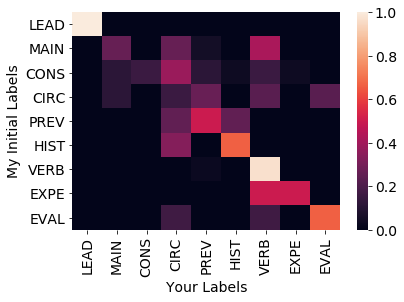

In [535]:
c_mat = confusion_matrix(both['label'], both['type'], labels=labels)
sns.heatmap(pd.DataFrame(c_mat, index=labels, columns=labels).pipe(lambda df: df.divide(df.sum(axis=1), axis=0)))
plt.ylabel('My Initial Labels')
plt.xlabel('Your Labels')

Text(0.5, 11.0, 'Your Labels')

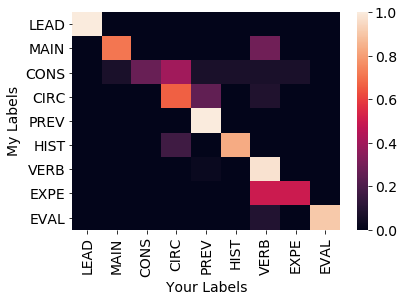

In [617]:
c_mat = confusion_matrix(both['my_updated_labels'], both['type'], labels=labels)
sns.heatmap(pd.DataFrame(c_mat, index=labels, columns=labels).pipe(lambda df: df.divide(df.sum(axis=1), axis=0)))
plt.ylabel('My Labels')
plt.xlabel('Your Labels')

In [528]:
both.loc[lambda df: df['my_updated_labels'] != df['type']].shape

(28, 14)

In [377]:
# both['my_updated_labels'] = both['label']

In [527]:
to_check = both.loc[lambda df: df['label'] != df['type']]

In [526]:
k = 66
t = to_check.iloc[k]
idx = t.name
t[['label', 'type', 'paragraph_text']].to_dict()

{'label': 'CONS',
 'type': 'MAIN',
 'paragraph_text': 'Annan, a Ghanaian facing by far the greatest diplomatic challenge of his 13\nmonths as secretary general, is due in Baghdad on Friday after a stop in Paris.\nHe said he will stay in Iraq for no more than two days before returning to brief\nthe Security Council.'}

In [ ]:
print(t['full_text'][:1000])

In [524]:
both.at[idx, 'my_updated_labels'] = t['type']

In [428]:
both.at[idx, 'my_updated_labels']

'CIRC'

In [ ]:
os.listdir('../data')

In [ ]:
both_final = (both.rename(columns={'label': 'my_first_labels', 'type': 'finlayson_labels'})
 [['doc_key_x', 'paragraph_text', 'start_x', 'end_x', 'my_first_labels', 'my_updated_labels', 'finlayson_labels']]
 .rename(columns=lambda x: x.replace('_x', ''))
)

both_final.to_csv('../data/my_checked_annotations.csv')

# Put it all together

In [59]:
both_final = pd.read_csv('../data/my_checked_annotations.csv', index_col=0)

In [60]:
other_labels = []

In [61]:
for article in glob.glob('../app/data/untagged_output/*'):
    with open(article) as f:
        for key, value in json.load(f).items():
            other_labels.extend(value)

In [62]:
new_data_df = pd.DataFrame(other_labels).loc[lambda df: df['question_class'] == 'label'].drop('question_class', axis=1)

In [63]:
input_data = json.load(open('../app/data/untagged_records.json'))
new_data_df = new_data_df.merge(pd.DataFrame(input_data), how='left', left_on='doc_key', right_on='doc_key')
new_data_df = (new_data_df
 .assign(full_text=lambda df: df['full_text'].str.replace(' \n', '\n'))
 .assign(start=lambda df: df.apply(lambda x: x['full_text'].index(x['paragraph_text']), axis=1))
 .assign(end=lambda df: df['start'] + df['paragraph_text'].str.len())
 .assign(doc_key=lambda df: df['doc_key'].str.replace('.sgm', ''))
 .drop('full_text', axis=1)
)

In [65]:
new_data_df['label'].value_counts().pipe(lambda s: s/s.sum())

VERB    0.288833
CIRC    0.186398
MAIN    0.170445
CONS    0.103275
EVAL    0.079765
PREV    0.051217
HIST    0.047859
LEAD    0.032746
EXPE    0.031906
EXPL    0.004198
SECD    0.003359
Name: label, dtype: float64

In [43]:
import pyperclip
pyperclip.copy(finlayson_annotation_df['type'].value_counts().pipe(lambda s: s/s.sum()).rename(full_map).round(2).to_latex())

In [68]:
data_df = pd.concat([
    finlayson_annotation_df
             .rename(columns={'text': 'paragraph_text', 'type': 'label'})
             [['doc_key', 'paragraph_text', 'start', 'end', 'label']]
            .loc[lambda df: ~df['doc_key'].isin(both_final['doc_key'])]
            .assign(corpus='finlayson'),
    both_final
            .rename(columns={'my_updated_labels': 'label'})
            [['doc_key', 'paragraph_text', 'start', 'end', 'label']]
            .assign(corpus='finlayson_corrected'),
    new_data_df[['doc_key', 'paragraph_text', 'start', 'end', 'label']]
            .assign(corpus='new')
])

In [69]:
data_df.to_csv('../data/combined_data_df.csv', index=False)